# Counting analysis 🚀🚀

In this notebook, we will look at frequencies of biblicle text on the following syntax levels:

* word: part of speech
* phrase: function, type
* clause: type

## Import main libraries

In [1]:
#Data
from functions.bhsa import get_data, unique, lbh_books, sbh_books # <- here's the new data data load statement -CK

#Storing data
import pandas as pd
import numpy as np

#printing
from pprint import pprint
import matplotlib.pyplot as plt

#Frequency counting
import collections
from itertools import chain

#Distance functions
from scipy.spatial.distance import pdist

#Plotting frequencies
from numpy.polynomial import Polynomial

#Correlation
from scipy.stats import pearsonr, kendalltau, spearmanr

#Linear regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress

#Divergence
from numpy.linalg import norm
from scipy.stats import entropy

#Hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram


In [2]:
all_data = get_data()

## Data

In [3]:
level = "phrase_functions"

data = all_data[level]
unique_functions = unique(otype='phrase', feature='function') 

print("Lbh_books:",lbh_books)
print("Sbh_books:",sbh_books)
print("Level: ", level)
print("Unique functions:",unique_functions)

Lbh_books: {'Ezra', '2_Chronicles', 'Esther', 'Nehemiah', '1_Chronicles'}
Sbh_books: {'Judges', 'Leviticus', 'Exodus', 'Deuteronomy', 'Genesis', '2_Kings', '2_Samuel', '1_Kings', '1_Samuel', 'Joshua'}
Level:  phrase_functions
Unique functions: ['Pred', 'Conj', 'Subj', 'Cmpl', 'Objc', 'PreC', 'Adju', 'Rela', 'Nega', 'PreO', 'Time', 'Modi', 'Loca', 'Intj', 'Voct', 'Ques', 'Frnt', 'PreS', 'NCop', 'IntS', 'PrAd', 'Supp', 'PtcO', 'Exst', 'NCoS', 'ModS', 'EPPr', 'ExsS', 'PrcS']


### Counting frequencies

We want to count the occurences of feature values. Therefore, two matrices should be computed: one with the raw counts of feature values and one for the probabilisties on each feature value for each book. This means that all raw count are divided by the sum of feature values.

In [4]:
def make_counts(feature_dict):
    '''
    Return a dictionary with frequency counts of the feature values.
    Requires a feature dict: feature[book] = list(list()*N)
    '''
    feature_count = dict() # counts here

    # loop and count
    for bookname, units in feature_dict.items():
        feature_count[bookname] = collections.Counter(list(chain(*units))) 

    # make into dataframe
    df_Count = pd.DataFrame(feature_count, columns=feature_dict.keys()).fillna(0)
    df_Prob = df_Count.div(df_Count.sum(axis=0), axis=1)
    
    # return both count and probability objects
    return  df_Count, df_Prob

In [5]:
df_Count, df_Prob = make_counts(data)
df_Count.head(10)

,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Adju,173.0,1136,168.0,19.0,59.0,115.0,99.0,76.0,103.0,169.0,155.0,60.0,842,79.0,84.0,243.0,376.0
Cmpl,1252.0,6877,563.0,155.0,222.0,665.0,805.0,899.0,746.0,752.0,818.0,211.0,1895,109.0,288.0,416.0,871.0
Conj,2621.0,12890,1211.0,219.0,338.0,988.0,1426.0,1778.0,1388.0,1422.0,1499.0,288.0,3407,189.0,525.0,837.0,1568.0
Exst,4.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1.0,3.0,0.0,0.0
Frnt,14.0,100,12.0,0.0,0.0,10.0,5.0,9.0,9.0,28.0,13.0,1.0,37,2.0,2.0,10.0,22.0
IntS,1.0,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,12,0.0,0.0,2.0,10.0
Intj,42.0,141,12.0,1.0,2.0,3.0,18.0,20.0,12.0,15.0,16.0,0.0,7,0.0,1.0,0.0,6.0
Loca,120.0,663,122.0,8.0,25.0,55.0,57.0,61.0,56.0,79.0,80.0,11.0,214,17.0,53.0,41.0,92.0
ModS,4.0,11,0.0,0.0,0.0,0.0,2.0,1.0,1.0,3.0,0.0,1.0,1,0.0,0.0,0.0,0.0
Modi,86.0,408,52.0,8.0,9.0,36.0,37.0,49.0,51.0,45.0,35.0,8.0,98,7.0,19.0,24.0,40.0


As can be seen, each column contains zeros or is below 5. Therefore, we cannot compute a chi-square test to test whether the frequencies of feature values is significant different between books. http://www.simafore.com/blog/bid/56480/2-key-assumptions-to-be-aware-of-before-applying-the-chi-square-test.

# Plotting the frequencies between books

We want to know how similar or dissimilar the frequencies of feature values between books are. Therefore, we may want to plot the frequencies of different feature values from book A and compare these with the frequencies of the same feature values from a book B. We interpret each column as a vector and plot the values of these vectors against another. 

In [6]:
def plot_occurences(df, books):
    '''
    Plot each frequency 
    '''
    n = len(books)
    plt.close('all')
    f, axarr = plt.subplots(n, n,figsize=(25,25))
    for indexi,i in enumerate(books):
        for indexj,j in enumerate(books):
            x = np.array(df[i].values)
            y = np.array(df[j].values)
            p = Polynomial.fit(x, y, 1) #Fit a straight line through the points
            
            #Plot frequencies
            axarr[indexj, indexi].plot(x,y, 'ro') #plot frequencies
            axarr[indexj, indexi].plot(*p.linspace(), color='blue') #Plot the line
            axarr[indexj, indexi].set_xlabel(i,fontsize=18)
            axarr[indexj, indexi].set_ylabel(j,fontsize=18)
    plt.show() 

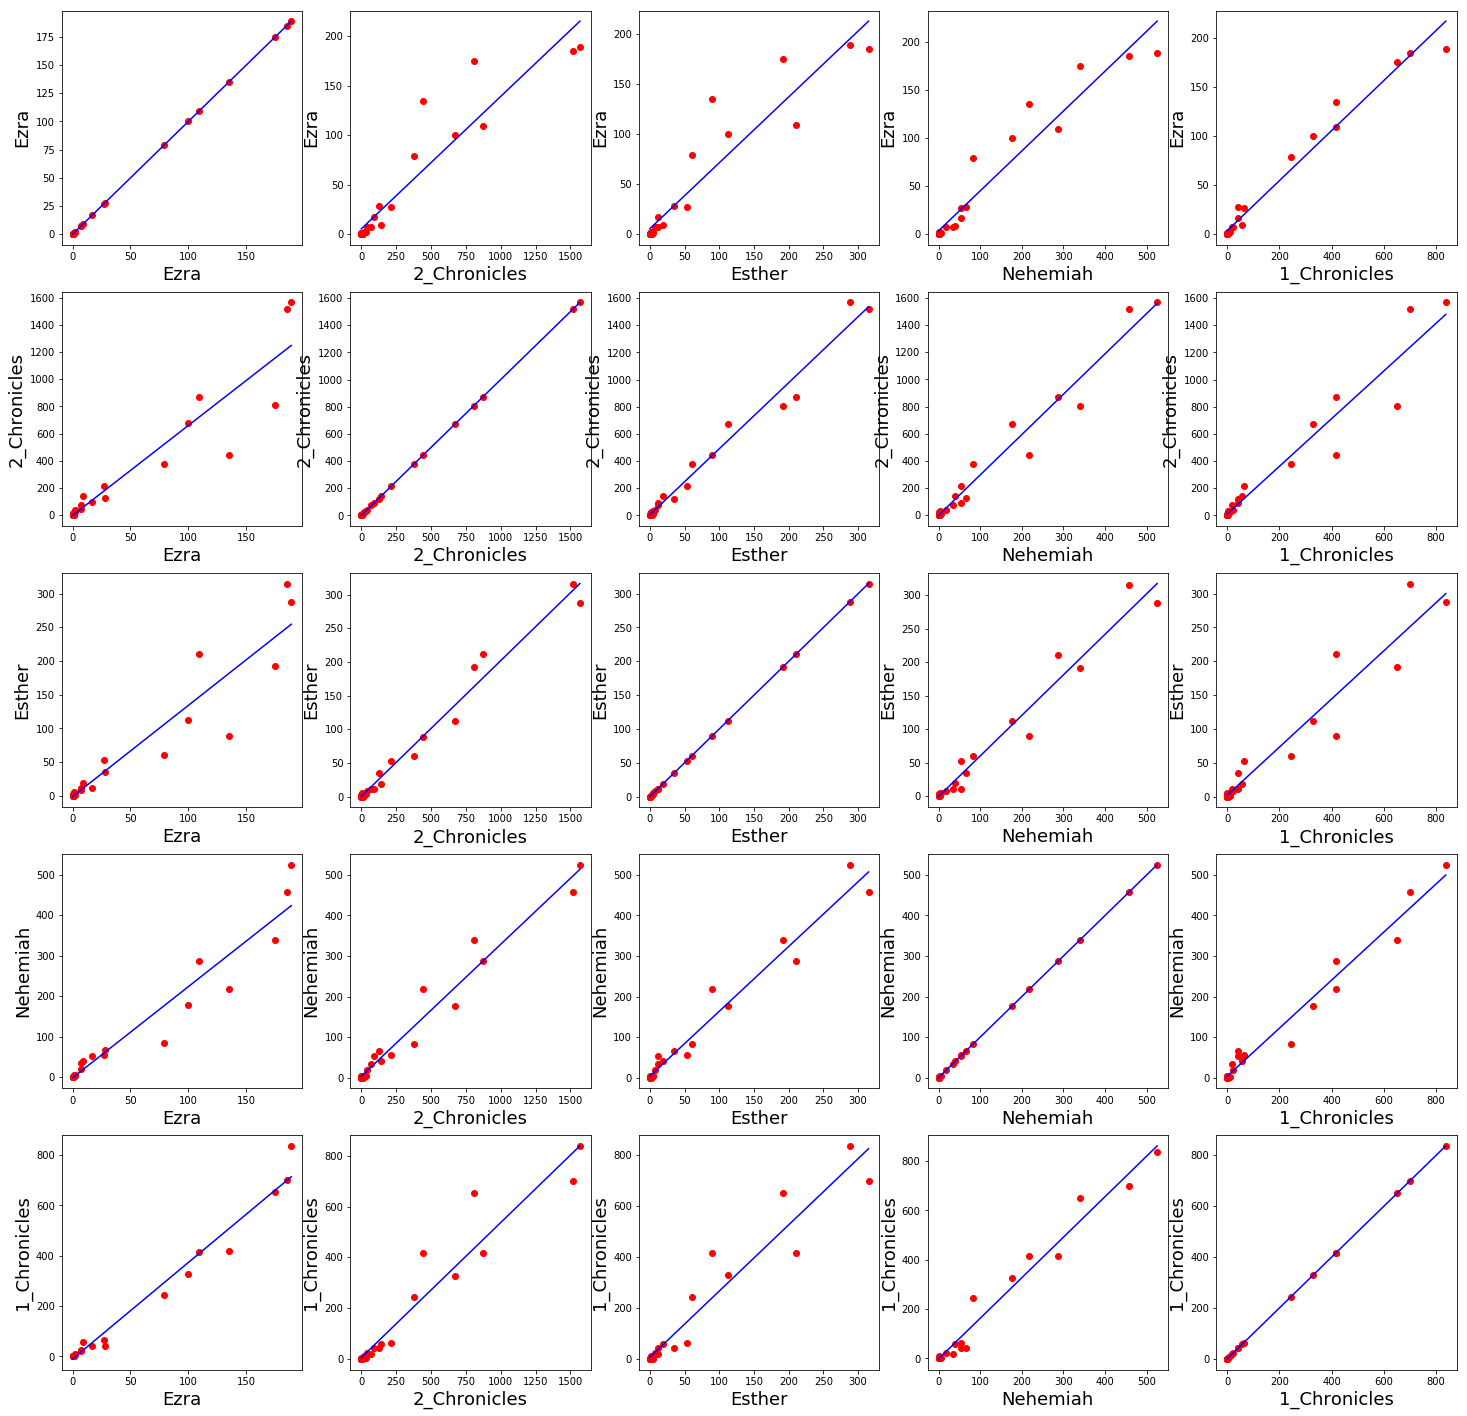

In [7]:
plot_occurences(df_Count, list(lbh_books))

We can observe here that books where the points are closer to the straight line are more similar than books where this is not the case. We can also see that there is a positive correlation between the number of frequencies. Similar books show that a higher number of occurences in book A will also occur in book B. We want thus some measure that indicates how similar the books in frequencies are or how dissimilar. 

# Distance measurements frequencies

In the simplest form distance measures are mathematical approaches to measure distance between the objects. Computing distance measures helps us to compare the objects from three different standpoints such as.
* Similarity are measure that range from 0 to 1 [0, 1]
* Dissimilarity is measures that range from 0 to INF [0, Infinity]
* Correlation is measures that range from +1 to -1 [+1, -1]


http://shakthydoss.com/technical/distance-measures-similarity-dissimilarity-correlation/

## Distance functions

Measurements:
(s,sq)euclidean, (w)minkowski, cosine, canberra, braycurtis, mahalanobis, other f

These distances are to be forgotten: 
* Boolean vectors: yule,dice, rogerstanimoto, russellrao,sokalmichener,sokalsneath,kulsinski
* Manhatten distance: cityblock
* Strings: hamming
* Number of same frequency/ n: jaccard
* max norm distance: chebyshev

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

## Correlation

"Correlation is a bivariate analysis that measures the strength of association between two variables and the direction of the relationship. In terms of the strength of relationship, the value of the correlation coefficient varies between +1 and -1.  A value of ± 1 indicates a perfect degree of association between the two variables.  As the correlation coefficient value goes towards 0, the relationship between the two variables will be weaker.  The direction of the relationship is indicated by the sign of the coefficient; a + sign indicates a positive relationship and a – sign indicates a negative relationship."

http://www.statisticssolutions.com/correlation-pearson-kendall-spearman/

In correlation tests, we want to test whether two variables are dependent. In these tests, the null hypothesis that could be rejected is that two variables are independent. 

Bijma, F., Gunst, de M.C.M. (2015) Statistical Data Analysis. VU University Amsterdam

Correlation is a statistical technique that gives a number telling how strongly or weekly the relationship between the objects. It is not a measure describing the distance but a measure describes the bound between the objects.

http://shakthydoss.com/technical/distance-measures-similarity-dissimilarity-correlation/

#### Pearson correlation

The pearson does assume that both X and Y come from a bivariat normal distribution. Therefore this is a parametric distribution. Since the frequencies are not normally distributed, this test is not appropriate. 

Chen, P. Y., & Popovich, P. M. (2002). Correlation: Parametric and nonparametric measures. Thousand Oaks, CA: Sage Publications page 13-14 https://rufiismada.files.wordpress.com/2012/02/correlation__parametric_and_nonparametric_measures__quantitative_applications_in_the_social_sciences_.pdf 


#### Spearman rank correlation

This test is a non-parametric test that is used to measure the dependency between variables. For the Spearmann test, the null hypothesis is rejected if the statistic is close to -1 or 1. The assumptions of the Spearman correlation are that data must be at least ordinal and the scores on one variable must be monotonically related to the other variable. 


#### Kendall rank correlation

Kendall is a non-parametric test that looks at the relation between two variables.

Kendall: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kendalltau.html
Pearson: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html
Spearman:https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html




### Correlation as distance

Suggested in the under mentioned websites are the four following versions of transforming correlation to distance:
* 1) Dissimilarity = 1 - Correlation
* 2) Dissimilarity = (1 - Correlation)/2
* 3) Dissimilarity = 1 - Abs(Correlation)
* 4) Dissimilarity = Sqrt(1 - 2*Correlation) 

3) http://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/pear_dis.htm
4) http://84.89.132.1/~michael/stanford/maeb6.pdf

http://research.stowers.org/mcm/efg/R/Visualization/cor-cluster/index.htm

Restrictions on clustering with correlations
https://stats.stackexchange.com/questions/165194/using-correlation-as-distance-metric-for-hierarchical-clustering

## Other measures?

### Linear regression

Another idea to measure the similarity is fitting a linear model on the frequencies and look how good the model fits. The score of a model (0-1) indicates how good the model fits on the data points. In each comparison, a model of the form 

y=ax+b 

is fit on the frequencies and the score of the model can indicate how good the model fits. Here, x and y are the frequency vectors of the books that we want to compare. The same as in correlation, converting this score to dissimilarity can be computed in multiple versions.
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression

### Divergence

Interesting is else does not work. https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence

## Functions for distances

In [48]:
def distance_measurement(X, method):
    "Options: (s,sq)euclidean,(w)minkowski, cosine, canberra, braycurtis, mahalanobis, correlation"
    return pdist(X, method)

#Correlation
def pearsonCorrelation(x, y):#Maybe not use this by rejecting assumption
    "Returns stats, p"
    return pearsonr(x,y)

def kendaltauCorrelation(x,y):
    "Returns stats, p"
    return kendalltau(x,y)

def spearmanCorrelation(x,y): 
    "returns rho, p"
    return spearmanr(x,y)

#Linear model
def lineairModelScore(x,y):
    x = np.matrix(x).transpose()
    regr = linear_model.LinearRegression(fit_intercept = True) #Note, we take the intercept. Usefull for symmetry of distance.
    regr.fit(x,y) #Fit the model
    return regr.score(x,y)

def lineairModelPvalue(x,y):
    #Results of linear model
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    return(p_value)

#Convert correlation and score to distance
def to_distance(value):
    "Uses one of the transformation function to convert value to distance"
    distance = round(1-value,7)
    return distance

## Create distance metric


A distance metric should have the following properties: 
* Distance positive
* Distance to itself should be 0
* Symmetric distances
* Triangle inequality

https://en.wikipedia.org/wiki/Metric_(mathematics)

### Functions for distance metric

In [49]:
def correlationDistance(x,y):
    cor, p_value  = kendaltauCorrelation(x,y)
    distance = to_distance(cor)
    return distance

def linearModelDistance(x,y):
    score  = lineairModelScore(x,y)
    distance = to_distance(score)
    return distance

def createDistanceMetric(df, books):
    df_dist = pd.DataFrame(np.zeros((len(books),len(books))), columns = books, index = books)
    
    for indexi, i in enumerate(books):
        for indexj, j in enumerate(books):
            x = np.array(df[i].values)
            y = np.array(df[j].values)
            
            df_dist.loc[i,j] = correlationDistance(x,y)
    return df_dist
    

## Hierarchical Clustering

Tutorial in hierarchical clustering
http://people.revoledu.com/kardi/tutorial/Clustering/Distance%20Matrix.htm
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

Methods to do hierarchical clustering
* Single
* Complete
* Average
* Weighted
* Ward
* Median
* Centroid

Usage in python
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html


## Functions for clustering

In [50]:
def hierarchical_clustering1(distanceMatrix, method, books):
    Z = linkage(distanceMatrix,  method)
    plt.figure(figsize=(25, 10))
    dendrogram(Z, labels = books)
    plt.show()
    
def hierarchical_clustering2(df_Count, method, distancemeasure, books):
    Z = linkage(df_Count,  method, distancemeasure)
    plt.figure(figsize=(25, 10))
    dendrogram(Z, labels = books)
    plt.show()

# Analysis

In [51]:
df_Dist = createDistanceMetric(df_Count, list(data.keys()))
print(np.allclose(df_Dist.values, df_Dist.values.T, atol=1e-8)) #Check symmetry of distance matrix 
df_Dist

True


,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Genesis,0.000000,0.070234,0.105313,0.117707,0.237564,0.130967,0.106208,0.114819,0.084662,0.100666,0.112594,0.164143,0.155362,0.123074,0.154400,0.183263,0.192526
sbh,0.070234,0.000000,0.091705,0.124880,0.196164,0.106732,0.069107,0.091170,0.081271,0.040263,0.055450,0.126461,0.121577,0.151024,0.154400,0.152378,0.135091
Exodus,0.105313,0.091705,0.000000,0.149997,0.227994,0.147755,0.104598,0.127127,0.096546,0.109132,0.131562,0.181165,0.158056,0.150675,0.170983,0.190196,0.178675
Leviticus,0.117707,0.124880,0.149997,0.000000,0.130583,0.094057,0.153639,0.152196,0.098390,0.143530,0.113247,0.155074,0.155819,0.168253,0.180598,0.157268,0.148573
Deuteronomy,0.237564,0.196164,0.227994,0.130583,0.000000,0.174995,0.220670,0.222827,0.174699,0.207309,0.147025,0.215528,0.243737,0.261203,0.239836,0.246007,0.205401
Joshua,0.130967,0.106732,0.147755,0.094057,0.174995,0.000000,0.137575,0.125612,0.098046,0.103729,0.084817,0.163073,0.083642,0.124738,0.159773,0.090550,0.076647
Judges,0.106208,0.069107,0.104598,0.153639,0.220670,0.137575,0.000000,0.076660,0.107681,0.099819,0.108469,0.122519,0.161839,0.182592,0.164364,0.204033,0.168653
1_Samuel,0.114819,0.091170,0.127127,0.152196,0.222827,0.125612,0.076660,0.000000,0.075337,0.108454,0.137510,0.166010,0.163823,0.170610,0.193814,0.192276,0.156997
2_Samuel,0.084662,0.081271,0.096546,0.098390,0.174699,0.098046,0.107681,0.075337,0.000000,0.108797,0.110700,0.173566,0.160954,0.146516,0.187606,0.158198,0.154105
1_Kings,0.100666,0.040263,0.109132,0.143530,0.207309,0.103729,0.099819,0.108454,0.108797,0.000000,0.062393,0.109776,0.115234,0.155181,0.168595,0.128870,0.108454


option clustering :Single,Complete,Average,Weighted,Ward,Median,Centroid

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


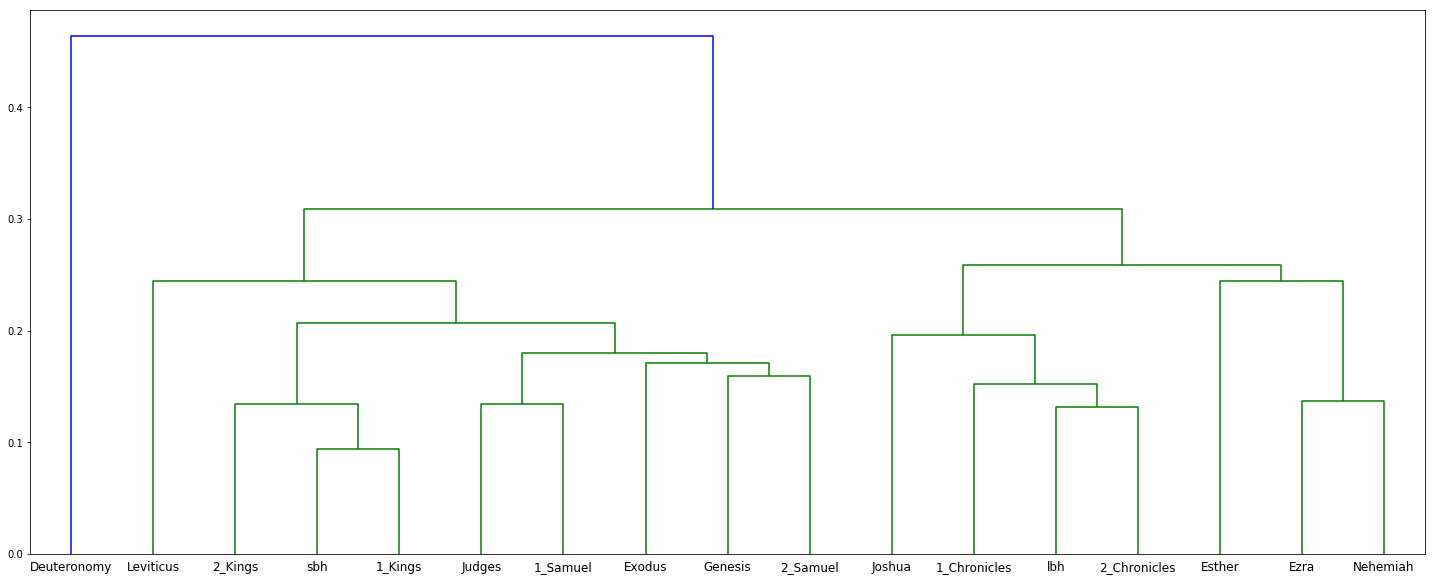

In [64]:
hierarchical_clustering1(np.matrix(df_Dist.values),"average", list(data.keys()))
#hierarchical_clustering2(np.matrix(df_Count.values).transpose(),"single", "euclidean", list(data.keys()))